In [1]:
def plot_less_data(data):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    axis_fontsize = 11

    # plot the nominal

    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    ax = axs[0]
    ax.set_xscale('log', basex=2)

    import matplotlib.ticker
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    data['source_eps'].astype(str)

    red_v = sns.color_palette('Reds', 5)
    blue_v = sns.color_palette('Greens', 5)

    p = {0: sns.xkcd_rgb["grey"],
         3: sns.xkcd_rgb["teal"],
         4: sns.xkcd_rgb["royal blue"]}

    sns.lineplot(x='num_training_images', y='nat_prec1', hue='source_eps', marker='o',
                 data=data, ci=99, ax=ax, palette=p)

#     ax.lines[2].set_linestyle((0,(1,10)))
#     ax.lines[1].set_linestyle(":")
    
    ax.lines[0].set_markeredgecolor(sns.xkcd_rgb["dark grey"])
    
    ax.lines[1].set_marker("^")
    ax.lines[1].set_markeredgecolor(sns.xkcd_rgb["dark blue"])
    
    ax.lines[2].set_marker("s")
    ax.lines[2].set_markeredgecolor(sns.xkcd_rgb["black"])
    

    

    ax.set_xticks(np.sort(data['num_training_images'].unique()))
    ax.set_xlabel('Number of training images (log scale)')
    ax.set_ylabel('Accuracy %')
    # ax.set_title('Accuracy of pre-trained robust and a non-robust model')
    ax.legend(['$\epsilon$= 0.0','$\epsilon$= 3.0', '$\epsilon$= 4.0'], title='Source \nrobustness')
    ax.tick_params(axis='x', labelrotation=45)


    # get the delta

    source_eps_0 = data[data['source_eps'] == 0].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
    source_eps_3 = data[data['source_eps'] == 3].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
    source_eps_4 = data[data['source_eps'] == 4].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

    new_data_1 = source_eps_0.copy()
    new_data_1['nat_prec1_delta'] = source_eps_3['nat_prec1'] - source_eps_0['nat_prec1']
    new_data_1['eps_vs_nat'] = 3

    new_data_2 = source_eps_0.copy()
    new_data_2['nat_prec1_delta'] = source_eps_4['nat_prec1'] - source_eps_0['nat_prec1']
    new_data_2['eps_vs_nat'] = 4

    new_data = pd.DataFrame()
    new_data = new_data.append(new_data_1).append(new_data_2)

    #plot the delta

    import seaborn as sns
    import matplotlib.pyplot as plt

    ax = axs[1]
    ax.set_xscale('log', basex=2)

    import matplotlib.ticker
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    data['source_eps'].astype(str)
    sns.lineplot(x='num_training_images', y='nat_prec1_delta', hue='eps_vs_nat', marker='o', data=new_data, ci=99, ax=ax, palette=p)


    ax.set_xticks(np.sort(data['num_training_images'].unique()))
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlabel('Number of training images (log scale)')
    ax.set_ylabel('Accuracy delta %')
    # ax.set_title('Accuracy delta between a pre-trained robust vs non-robust model')

    #ax.lines[0].set_linestyle("--")
    #ax.lines[1].set_linestyle(":")
    
    ax.lines[0].set_marker("^")
    ax.lines[0].set_markeredgecolor(sns.xkcd_rgb["dark blue"])
    
    ax.lines[1].set_marker("s")
    ax.lines[1].set_markeredgecolor(sns.xkcd_rgb["black"])
    
    ax.legend(['$\epsilon$= 3.0 minus $\epsilon$= 0.0', '$\epsilon$= 4.0 minus $\epsilon$= 0.0'], title='Accuracy delta')


    plt.suptitle('Transfer ResNet50 from ImageNet to CIFAR10 with unfrozen FC layer')

    plt.tight_layout;

In [2]:
import pandas as pd

data = pd.read_csv('apr15.csv')

In [3]:
from IPython.display import display
pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)

# replace -1 and 60,000 with 50,000
data = data.replace({'num_training_images':{-1:50000, 60000:50000}})
data = data.drop_duplicates()

# grab only the relevant seeds for the exp
relevant_seeds = data['seed'].unique()[data['seed'].unique() >= 20000000]
clean_data = data[data['seed'].isin(relevant_seeds)]

# see the difference between the best vs the last
last_df = clean_data.groupby(by=['num_training_images', 'seed', 'source_eps', 'unfrozen_blocks']).apply(lambda x: x[x['epoch'] == max(x['epoch'])]).reset_index(drop=True)

best_df = clean_data.groupby(by=['num_training_images', 'seed', 'source_eps', 'unfrozen_blocks']).apply(lambda x: x[x['nat_prec1'] == max(x['nat_prec1'])]).reset_index(drop=True)
inc = ['num_training_images', 'seed', 'source_eps', 'unfrozen_blocks', 'nat_prec1']
best_df = best_df.drop_duplicates(subset=inc).reset_index(drop=True)


In [11]:
last_df.groupby(by=['num_training_images']).count()

,Unnamed: 0,epoch,nat_prec1,adv_prec1,nat_loss,adv_loss,train_prec1,train_loss,time,source_eps,target_ds,unfrozen_blocks,seed
num_training_images,,,,,,,,,,,,,
100,90,90,90,90,90,90,90,90,90,90,90,90,90
200,90,90,90,90,90,90,90,90,90,90,90,90,90
400,90,90,90,90,90,90,90,90,90,90,90,90,90
800,90,90,90,90,90,90,90,90,90,90,90,90,90
1600,90,90,90,90,90,90,90,90,90,90,90,90,90
3200,90,90,90,90,90,90,90,90,90,90,90,90,90
6400,90,90,90,90,90,90,90,90,90,90,90,90,90
12800,45,45,45,45,45,45,45,45,45,45,45,45,45
25600,45,45,45,45,45,45,45,45,45,45,45,45,45


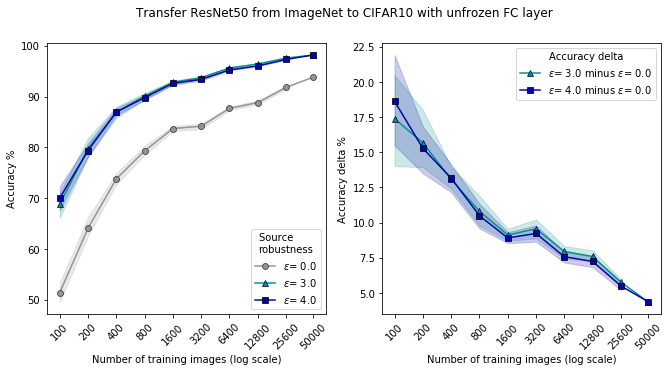

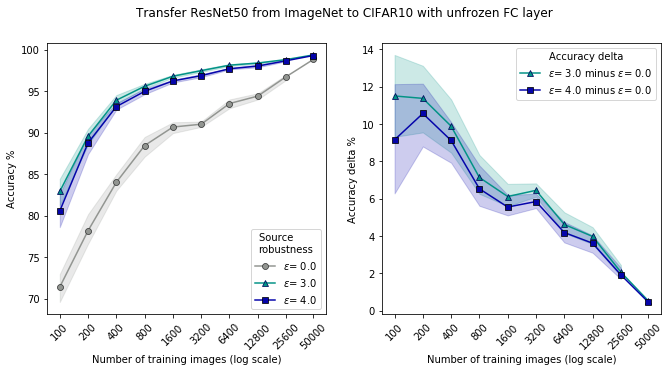

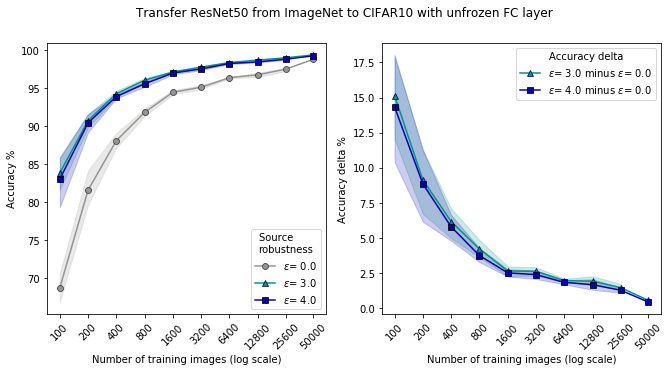

In [6]:
plot_less_data(last_df[last_df['unfrozen_blocks'] == 0])
plot_less_data(last_df[last_df['unfrozen_blocks'] == 1])
plot_less_data(last_df[last_df['unfrozen_blocks'] == 3])

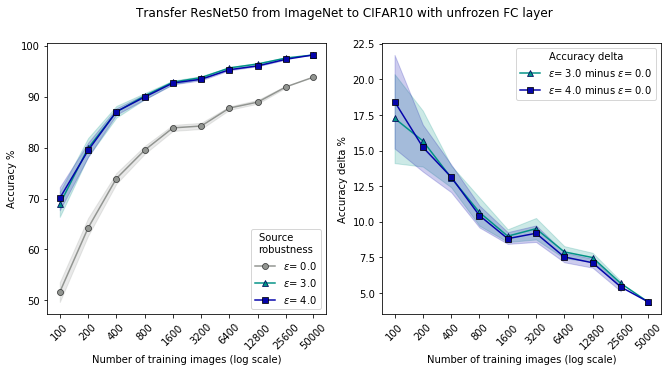

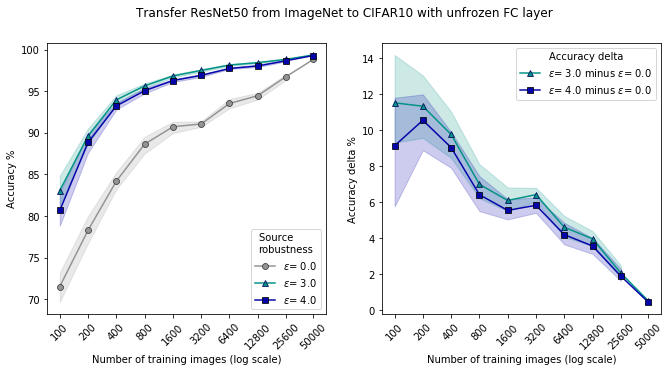

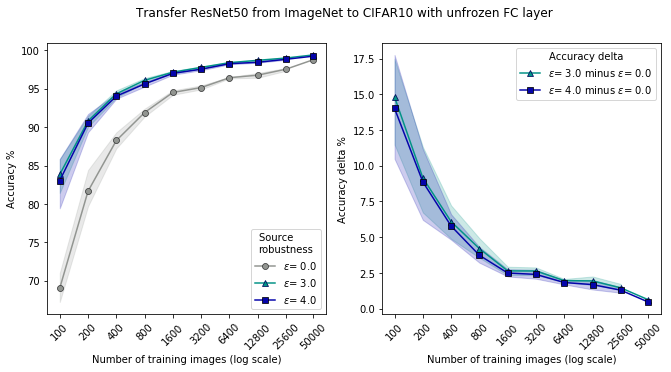

In [7]:
plot_less_data(best_df[best_df['unfrozen_blocks'] == 0])
plot_less_data(best_df[best_df['unfrozen_blocks'] == 1])
plot_less_data(best_df[best_df['unfrozen_blocks'] == 3])

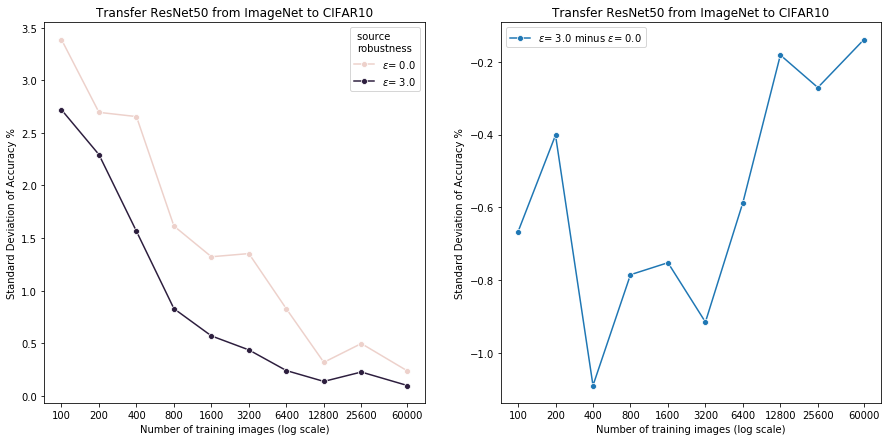

In [49]:
# get std data

import numpy as np

std_data = data.groupby(by=['num_training_images', 'source_eps'], as_index=True).std(ddof=1).loc[:, ['nat_prec1']]

std_data = var_data.reset_index()
std_data = var_data.rename(columns={'nat_prec1':'std'})

# plot std

import seaborn as sns
import matplotlib.pyplot as plt

plt, axs = plt.subplots(1, 2, figsize=(15, 7))

ax = axs[0]
ax.set_xscale('log', basex=2)

import matplotlib.ticker
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

data['source_eps'].astype(str)
sns.lineplot(x='num_training_images', y='std', hue='source_eps', marker='o', data=std_data, ci=99, ax=ax)

ax.set_xticks(data['num_training_images'].unique())
ax.set_xlabel('Number of training images (log scale)')
ax.set_ylabel('Standard Deviation of Accuracy %')
ax.set_title('Transfer ResNet50 from ImageNet to CIFAR10');
ax.legend(['$\epsilon$= 0.0','$\epsilon$= 3.0'], title='source \nrobustness');

# get variance delta

std_eps_0 = std_data[var_data['source_eps'] == 0].reset_index(drop=True)
std_eps_3 = std_data[var_data['source_eps'] == 3].reset_index(drop=True)

std_delta = std_eps_0.copy()

std_delta['std_delta'] = std_eps_3['std'] - std_eps_0['std']

ax = axs[1]
ax.set_xscale('log', basex=2)

import matplotlib.ticker
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

data['source_eps'].astype(str)
sns.lineplot(x='num_training_images', y='std_delta', marker='o', data=std_delta, ci=99, ax=ax)

ax.set_xticks(data['num_training_images'].unique())
ax.set_xlabel('Number of training images (log scale)')
ax.set_ylabel('Standard Deviation of Accuracy %')
ax.set_title('Transfer ResNet50 from ImageNet to CIFAR10');
ax.legend(['$\epsilon$= 3.0 minus $\epsilon$= 0.0']);

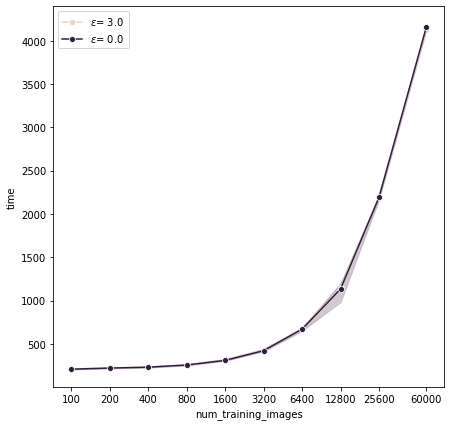

In [52]:
# how long does it take?
import matplotlib.pyplot as plt

plt, ax = plt.subplots(figsize=(7, 7))
ax.set_xscale('log', basex=2)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

sns.lineplot(x='num_training_images', y='time', hue='source_eps', marker='o', data=data, ci=99)
ax.set_xticks(data['num_training_images'].unique())
ax.legend(['$\epsilon$= 3.0', '$\epsilon$= 0.0']);

**Thesis -** Transfer learning from a robust model is better (higher mean lower std) than a standard model

**Support -** Empirical results


**High-level experiment - Standard & replicable** [Proposed - Est. 3 days for 1 GPU]

* 6 datasets (cifar100, cifar10, svhn, kmnist, fmnist, mnist)
* 3 source eps levels/types (0, 3 l-2, 4 l-inf)
* 3 transfer methodologies (0, 1, 3 unfrozen blocks)
* 5 sample sizes (100, 400, 1600, 6400, entire training set)
* 3 seeds

**Case study -** CIFAR10 [DONE]

* More seeds (20) 
* More sample sizes(100, 200, 400, ... , 60000) 

Is that enough?

In [ ]:
clean_data.to_csv('MNIST.csv')